## 8IAR403 - Apprentissage machine pour la science des données

# Devoir #2

## Auteurs:
## -> Christian Hudon - HUDC04076909
## -> Alex Roberge - ROBA19129504
## Date de remise: 15 mars 2021

### Notes sur les données d'entrées

Notre avons initialement intégré la classification (binaire ou multiclasse) via paramétrisation de notre pipeline de TP1.
Celui-ci faisait déjà l'ajout optionnel des données de PIB (GDP). Pour ne pas inclure le traitement du TP1 dans ce TP,
nous avons donc séparé cette partie du traitement dans le fichier Preparation_Donnees_TP1.ipynb après votre consigne.
Cependant, comme les fonctions de labélisation (demandée au point 2.1.1 et 2.2.1) font partie intégrale de notre pipeline,
vous pourrez les trouver dans l'autre fichier. Ces fonctions sont nommées binary_label_encoder et category_label_encoder
respectivement.
<br>Ce TP utilise 4 TBA générés avec notre pipeline soit:
<ul>
<li>customers_bin_sans_gdp.csv: TBA avec revenue en classe binaire sans la colonne gpd</li>
<li>customers_bin_avec_gdp.csv: TBA avec revenue en classe binaire avec la colonne gpd</li>
<li>customers_cat_sans_gdp.csv: TBA avec revenue multiclasse sans la colonne gpd</li>
<li>customers_cat_avec_gdp.csv: TBA avec revenue multiclasse avec la colonne gpd</li>
</ul>

### Traitement extras
Comme la distribution de la colonne revenue avant transformation avait une distribution non normale
(Exponential-logarithmic distribution), classifier cette variable en 3 catégories comme demandé (+/- 2sigma) donnait
des classes très déséquilibrées.
<br/>Dans un premier temps, nous avons tenté de corriger le débalancement en effectuant de l'over-échantillonnage de type SMOTE.
La performance de nos modèles n'était pas très bonne avec cette méthode.
<br/>Dans un deuxième temps, nous avons appliqué une transformation Box-Cox (voir pipeline dans fichier TP1).
sur la variable revenue pour la ramener à une distribution normale avant de séparer en 3 classes. Ceci nous a donné un
meilleur équilibre entre nos trois classes. Améliorant la performance de nos modèles sans avoir besoin d'over échantillonnage.
Ref: https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203
<br/> Nous avons laissé le code de l'over-échantillonnage dans le TP même s'il ne sert plus.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython import InteractiveShell
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
InteractiveShell.ast_node_interactivity = "all"

# Initialise la grosseur de figures
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
#import import_ipynb
#from utilitaires.ipynb import *
%run utilitaires.ipynb

# TP2 - Question 2.1 - Entrainement d'un classeur binaire

In [3]:
# Lecture des données
customers_bin_sans_gdp = pd.read_csv("customers_bin_sans_gdp.csv")
customers_bin_avec_gdp = pd.read_csv("customers_bin_avec_gdp.csv")

In [4]:
# Sépare jeux de test final
train_data_avec_gdp, test_data_avec_gdp = train_test_split(customers_bin_avec_gdp, test_size=0.2, random_state=42)
train_data_sans_gdp, test_data_sans_gdp = train_test_split(customers_bin_sans_gdp, test_size=0.2, random_state=42)

### Question 2.1.1 - Écrire une fonction pour remplacer cette variable « revenu » par une variable binaire
Voir note de début de fichier

### Question 2.1.2 - Échantionnage stratifié et 2.1.3 Validation croisée

In [5]:
# Pour la section 2.1, nous utilisons un DescisionTree sans Paramètres
clf = DecisionTreeClassifier()

# Question 2.1.3 - Entraîner et tester par la validation croisée pour k = 3 et k = 10.
# Question 2.1.4 - Mesurer les métriques de précision, rappel et F1-Mesure.

In [6]:
# Fonction qui affiche les métriques (2.1.4)
def PredAndScore(clf, x, y, cv):
    """Fait la cv et print les résultats de la fonction ResampleAndScore en plus de retourner le score total"""

    y_pred = cross_val_predict(clf, x, y, cv=cv)

    print("***cv de {0}***\n".format(cv))
    print("matrice de confusion:\n",metrics.confusion_matrix(y,y_pred))
    print("\nmetrics accuracy score: ", metrics.accuracy_score(y,y_pred))
#    print("\nPrecisionscore: ",precision_score(y, y_pred))
#    print("\nRecall score: ",recall_score(y, y_pred))
#    print("\nF1_score: ",f1_score(y, y_pred))

    print(metrics.classification_report(y, y_pred))

    return metrics.accuracy_score(y, y_pred)

# Fonction qui effectue un echantillonnage une validation croisée
def ResampleAndScore(clf, Trainset, n_samples, cv):
    """La fonction fait la cross-validation et appelle l'autre fonction pour print les résultats."""
    sample = resample(Trainset, n_samples=n_samples, replace=False, random_state=0)
    xTrain, yTrain = split_xy(sample)
    print("--Pour",n_samples, "échantillons--")

    s1 = PredAndScore(clf, xTrain, yTrain, cv)

    del sample, xTrain, yTrain
    return s1

In [7]:
# Effectue toutes les validations croisées pour toutes les tailles d'échantillons et de valeurs kk
resultats = []
for n_samples in [2000, 4000, 6000, 8000]:
    for cv in [3, 10]:
        accuracy = ResampleAndScore(clf, train_data_avec_gdp, n_samples, cv)
        resultats.append({'n_samples': n_samples, 'gdp': 'Avec', 'cv': cv, 'accuracy': accuracy})
        accuracy = ResampleAndScore(clf, train_data_sans_gdp, n_samples, cv)
        resultats.append({'n_samples': n_samples, 'gdp': 'Sans', 'cv': cv, 'accuracy': accuracy})

--Pour 2000 échantillons--
***cv de 3***

matrice de confusion:
 [[796 205]
 [233 766]]

metrics accuracy score:  0.781
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78      1001
         1.0       0.79      0.77      0.78       999

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000

--Pour 2000 échantillons--
***cv de 3***

matrice de confusion:
 [[770 231]
 [233 766]]

metrics accuracy score:  0.768
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77      1001
         1.0       0.77      0.77      0.77       999

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

--Pour 2000 échantillons--
***cv de 10***

matrice de confusion:
 [[786 215]
 [238 761]]

metrics accuracy

Les prochaines lignes de code affichent les résultats des différents échantillons avec leur précision, rappel et F1-mesure.

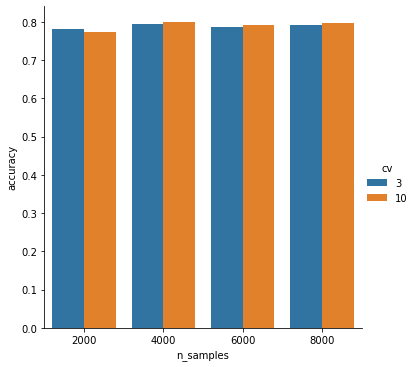

In [8]:
#Affiche les résultats Avec GPD
res_df=pd.DataFrame(resultats)
sns.catplot(data=res_df[res_df["gdp"]=="Avec"], x="n_samples", y="accuracy", hue="cv", kind="bar")

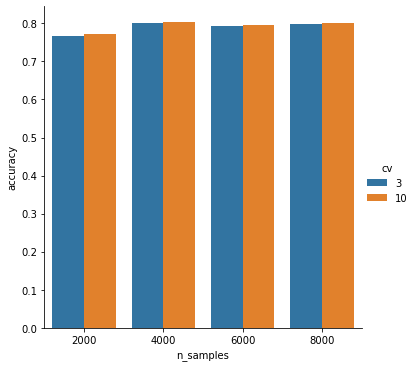

In [9]:
#Affiche les résultats Sans GPD
sns.catplot(data=res_df[res_df["gdp"]=="Sans"], x="n_samples", y="accuracy", hue="cv", kind="bar")

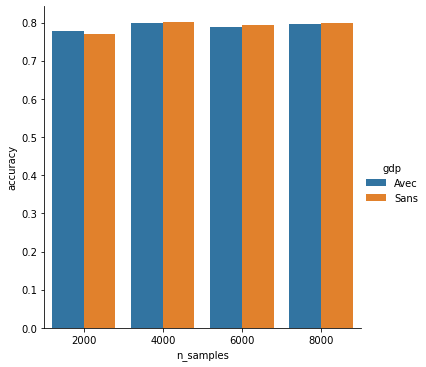

In [10]:
#Compare les résultats moyens Avec vs Sans gpd par n_samples
moy_df = res_df.groupby(['gdp', 'n_samples']).mean().reset_index()

sns.catplot(data=moy_df, x="n_samples", y="accuracy", hue="gdp", kind="bar")

### Question 2.1.5 - Entrainement avec GridSearchCV

In [11]:
# OverSampling
# À faire:
# 1- pip install imblearn
# 2- pip install delayed
# 3- restart jupyter

def over_sample(sample):
    xTrain, yTrain = split_xy(sample)
    oversample = SMOTE()
    X_sm, y_sm = oversample.fit_resample(xTrain, yTrain)
    print(y_sm.value_counts())
    return X_sm, y_sm

In [12]:
# Fonctions utilitaire pour l'entrainement
default_grid_params = {'max_depth': list(range(2, 20)), 'min_samples_split': [10, 15, 20]}
def train_classifer(classifer, train_data, grid_search_params, cv=10, n_samples=2000, over_sampling=False):
    # On prend un echantillon
    sample = resample(train_data)

    if over_sampling:
        xTrain, yTrain = over_sample(sample)
    else:
        xTrain, yTrain = split_xy(sample)

    # Définie le grid search
    grid_search = GridSearchCV(classifer, param_grid=grid_search_params, n_jobs=-1, verbose=3, cv=cv)

    # Fit
    grid_search.fit(xTrain, yTrain)

    #le meilleur estimateur (modele) trouvé est:
    return grid_search.best_estimator_

In [13]:
# Fonctions utilitaire pour l'entrainement
def test_classifer(classifier, test_data):
    x_test, y_test = split_xy(test_data)
    y_pred = classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='all')
    print(metrics.classification_report(y_test, y_pred))

    return accuracy, confusion_matrix

### Section 2.1.5 - Entrainement d'un classeur binaire

In [14]:
# Pour la section 2.1.5, on utilises un DecisionTreeClassifier avec paramêtres par défaut
clf = DecisionTreeClassifier(random_state=42)

### 2.1.5a Entrainement classificateur binaire Avec Gdp

In [15]:
clf_bin_avec_gpd = train_classifer(clf, train_data_avec_gdp, grid_search_params=default_grid_params, n_samples=8000, over_sampling=False)
clf_bin_avec_gpd

Fitting 10 folds for each of 54 candidates, totalling 540 fits


DecisionTreeClassifier(max_depth=19, min_samples_split=10, random_state=42)

### 2.1.6a Test classificateur multiclasse Avec Gdp

              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81      1003
         1.0       0.81      0.81      0.81       997

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000

Accuracy: 0.813


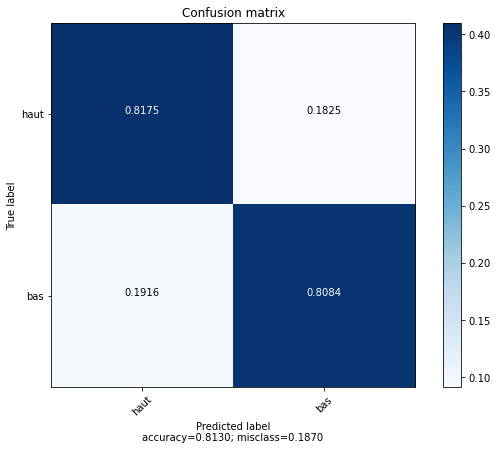

In [16]:
accuracy_bin_avec_gdp, confusion_matrix = test_classifer(clf_bin_avec_gpd, test_data_avec_gdp)
plot_confusion_matrix(confusion_matrix, ['haut', 'bas'])
print("Accuracy: {0}".format(accuracy_bin_avec_gdp))

## Entrainement et test de classificateur binaire Sans Gdp

### 2.1.5b Entrainement classificateur binaire Sans Gdp

In [17]:
clf_bin_sans_gpd = train_classifer(clf, train_data_sans_gdp, grid_search_params=default_grid_params, n_samples=8000, over_sampling=False)
clf_bin_sans_gpd

Fitting 10 folds for each of 54 candidates, totalling 540 fits


DecisionTreeClassifier(max_depth=19, min_samples_split=10, random_state=42)

### 2.1.6b Test classificateur multiclasse Sans Gdp

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      1003
         1.0       0.80      0.87      0.83       997

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Accuracy: 0.8255


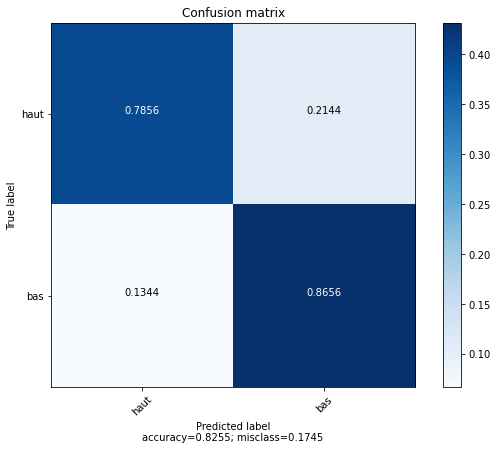

In [18]:
accuracy_bin_sans_gdp, confusion_matrix = test_classifer(clf_bin_sans_gpd, test_data_sans_gdp)
plot_confusion_matrix(confusion_matrix, ['haut', 'bas'])
print("Accuracy: {0}".format(accuracy_bin_sans_gdp))


### 2.1.7 - Représenter graphiquement et à l’aide de tableaux l’ensemble des résultats des métriques de performance

[]

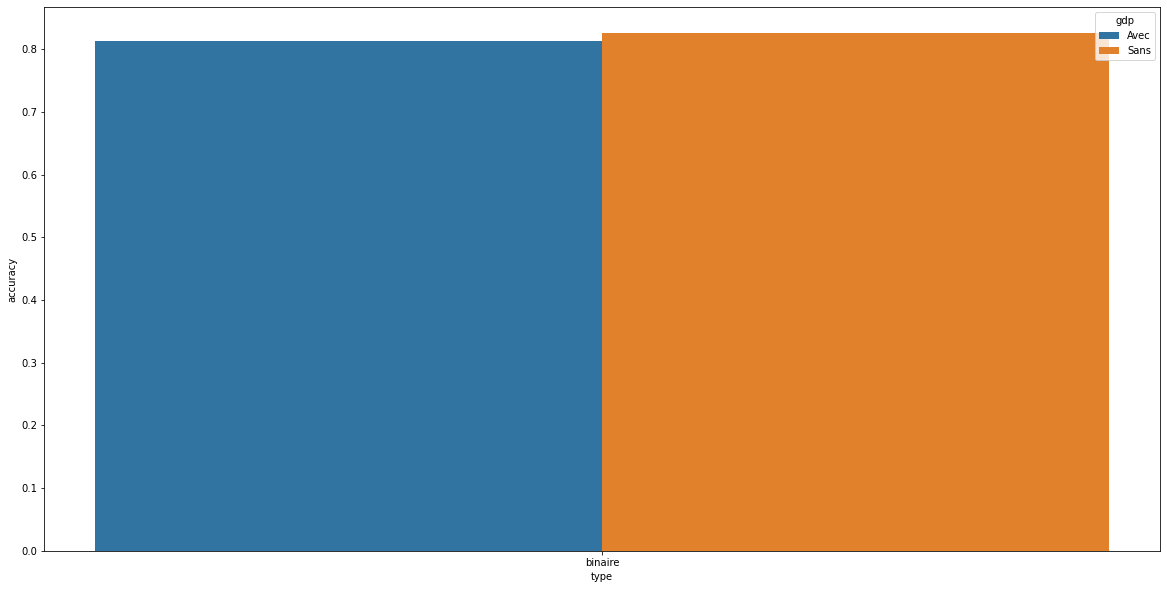

In [19]:
res_df = pd.DataFrame.from_dict(
    [
        {'type':'binaire', 'gdp':'Avec', 'accuracy':accuracy_bin_avec_gdp},
        {'type':'binaire', 'gdp':'Sans', 'accuracy':accuracy_bin_sans_gdp}
    ])
sns.barplot(data= res_df, x="type", y="accuracy", hue='gdp').plot()
plt.show()


### 2.1.8 - Analyser et interprétez les résultats obtenus.
<br/>Avec GDP, le meilleur modèle trouvé est: max_depth=19, min_samples_split=10
<br/>Sans GDP, le meilleur modèle trouvé est: max_depth=18, min_samples_split=10
<br/>Avec ou sans GDP nous obtenons sensiblement la même performance

# Section 2.2 - Entrainement d'un classeur multiclasse

### Question 2.2.1 - Écrire une fonction pour remplacer la variable « revenu » en multiclasse
Voir note de début de fichier

## Entrainement et test de classificateur multiclasse Avec Gdp

In [20]:
# Lecture des données
customers_cat_sans_gdp = pd.read_csv("customers_cat_sans_gdp.csv")
customers_cat_avec_gdp = pd.read_csv("customers_cat_avec_gdp.csv")

In [21]:
# Sépare jeux de test final
train_data_avec_gdp, test_data_avec_gdp = train_test_split(customers_cat_avec_gdp, test_size=0.2, random_state=42)
train_data_sans_gdp, test_data_sans_gdp = train_test_split(customers_cat_sans_gdp, test_size=0.2, random_state=42)

In [22]:
# Pour la section 2.2, on utiliser un DecisionTreeClassifier avec paramêtres par defaut
clf = DecisionTreeClassifier(random_state=42)


## Entrainement classificateur multiclasse Avec Gdp

In [23]:
clf_multi_avec_gpd = train_classifer(clf, train_data_avec_gdp, grid_search_params=default_grid_params, n_samples=8000, over_sampling=False)
clf_multi_avec_gpd

Fitting 10 folds for each of 54 candidates, totalling 540 fits


DecisionTreeClassifier(max_depth=18, min_samples_split=10, random_state=42)

## Test classificateur multiclasse Avec Gdp

              precision    recall  f1-score   support

         0.0       0.61      0.62      0.61       344
         1.0       0.79      0.80      0.79      1293
         2.0       0.63      0.58      0.60       363

    accuracy                           0.73      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.73      0.73      0.73      2000

Accuracy: 0.729


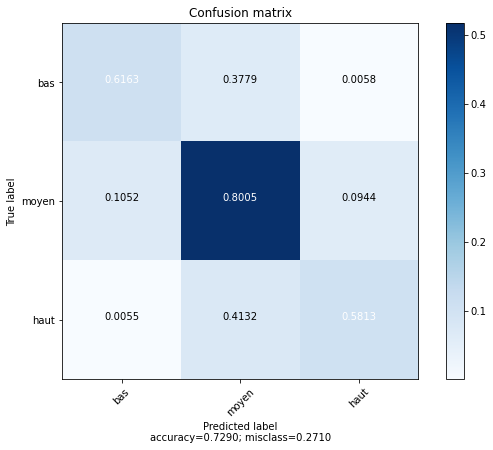

In [24]:
accuracy_multi_avec_gdp, confusion_matrix = test_classifer(clf_multi_avec_gpd, test_data_avec_gdp)
plot_confusion_matrix(confusion_matrix, ['bas', 'moyen', 'haut'])
print("Accuracy: {0}".format(accuracy_multi_avec_gdp))

# Entrainement et test de classificateur multiclasse Sans Gdp

## Entrainement classificateur multiclasse Sans Gdp

In [25]:
clf_multi_sans_gpd = train_classifer(clf, train_data_sans_gdp, grid_search_params=default_grid_params, n_samples=8000, over_sampling=False)
clf_multi_sans_gpd

Fitting 10 folds for each of 54 candidates, totalling 540 fits


DecisionTreeClassifier(max_depth=19, min_samples_split=10, random_state=42)

## Test classificateur multiclasse Sans Gdp

              precision    recall  f1-score   support

         0.0       0.72      0.60      0.65       344
         1.0       0.80      0.86      0.83      1293
         2.0       0.68      0.58      0.62       363

    accuracy                           0.77      2000
   macro avg       0.73      0.68      0.70      2000
weighted avg       0.76      0.77      0.76      2000

Accuracy: 0.766


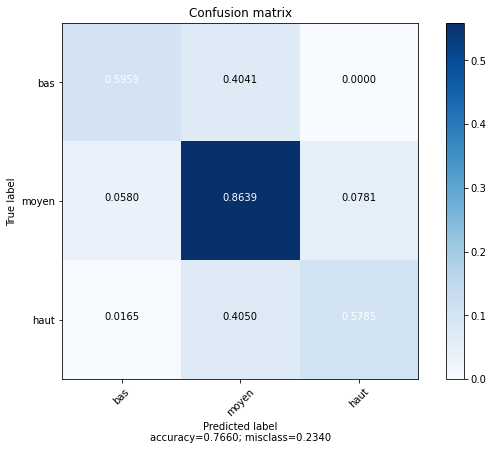

In [26]:
accuracy_multi_sans_gdp, confusion_matrix = test_classifer(clf_multi_sans_gpd, test_data_sans_gdp)
plot_confusion_matrix(confusion_matrix, ['bas', 'moyen', 'haut'])
print("Accuracy: {0}".format(accuracy_multi_sans_gdp))

### 2.2.2 Quel est le meilleur classeur pouvant discriminer les 3 revenus ?
<br/>Avec GDP, le meilleur modèle trouvé est: max_depth=19, min_samples_split=10
<br/>Sans GDP, le meilleur modèle trouvé est: max_depth=19, min_samples_split=10
<br/>Nous obtenons un meilleure performance sans la colonne GDP


### 2.2.3 Comparaison avec les classeurs binaires.
Conclusion: Les classeurs binaires sont plus performants.

[]

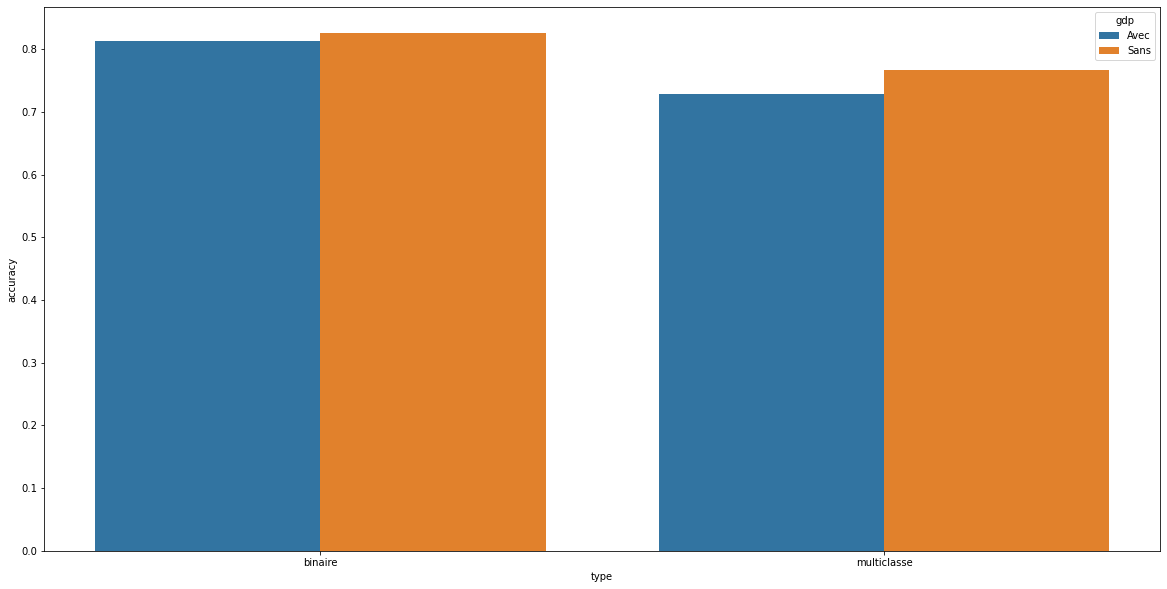

In [27]:
res_df = res_df.append(
    [
        {'type':'multiclasse', 'gdp':'Avec', 'accuracy':accuracy_multi_avec_gdp},
        {'type':'multiclasse', 'gdp':'Sans', 'accuracy':accuracy_multi_sans_gdp}
    ])
sns.barplot(data= res_df, x="type", y="accuracy", hue='gdp').plot()
plt.show()


# Section 2.3 - Entrainement d'un classeur multiclasse aléatoire

In [28]:
# Sépare jeux de test final
train_data_avec_gdp, test_data_avec_gdp = train_test_split(customers_cat_avec_gdp, test_size=0.2, random_state=42)
train_data_sans_gdp, test_data_sans_gdp = train_test_split(customers_cat_sans_gdp, test_size=0.2, random_state=42)

# Entrainement et test de classificateur multiclasse Avec Gdp

In [29]:
# Pour la section 2.3, on utilise un DecisionTreeClassifier avec splitter=random et max_features=log2
clf = DecisionTreeClassifier(random_state=42, splitter='random', max_features='log2')

## Entrainement classificateur multiclasse Avec Gdp

In [30]:
clf_multi_avec_gpd = train_classifer(clf, train_data_avec_gdp, grid_search_params=default_grid_params, n_samples=8000, over_sampling=False)
clf_multi_avec_gpd

Fitting 10 folds for each of 54 candidates, totalling 540 fits


DecisionTreeClassifier(max_depth=19, max_features='log2', min_samples_split=10,
                       random_state=42, splitter='random')

## Test classificateur multiclasse Avec Gdp

              precision    recall  f1-score   support

         0.0       0.60      0.27      0.37       344
         1.0       0.72      0.89      0.80      1293
         2.0       0.63      0.44      0.52       363

    accuracy                           0.70      2000
   macro avg       0.65      0.53      0.56      2000
weighted avg       0.68      0.70      0.67      2000

Accuracy: 0.7005


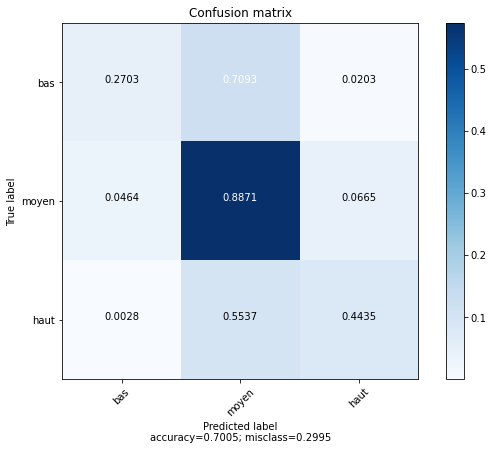

In [31]:
accuracy_random_avec_gdp, confusion_matrix = test_classifer(clf_multi_avec_gpd, test_data_avec_gdp)
plot_confusion_matrix(confusion_matrix, ['bas', 'moyen', 'haut'])
print("Accuracy: {0}".format(accuracy_random_avec_gdp))

# Entrainement et test de classificateur multiclasse Sans Gdp

## Entrainement classificateur multiclasse Sans Gdp

In [32]:
clf_multi_sans_gpd = train_classifer(clf, train_data_sans_gdp, grid_search_params=default_grid_params, n_samples=8000, over_sampling=False)
clf_multi_sans_gpd

Fitting 10 folds for each of 54 candidates, totalling 540 fits


DecisionTreeClassifier(max_depth=18, max_features='log2', min_samples_split=15,
                       random_state=42, splitter='random')

## Test classificateur multiclasse Sans Gdp

              precision    recall  f1-score   support

         0.0       0.63      0.14      0.23       344
         1.0       0.69      0.91      0.79      1293
         2.0       0.59      0.33      0.43       363

    accuracy                           0.68      2000
   macro avg       0.64      0.46      0.48      2000
weighted avg       0.66      0.68      0.63      2000

Accuracy: 0.6765


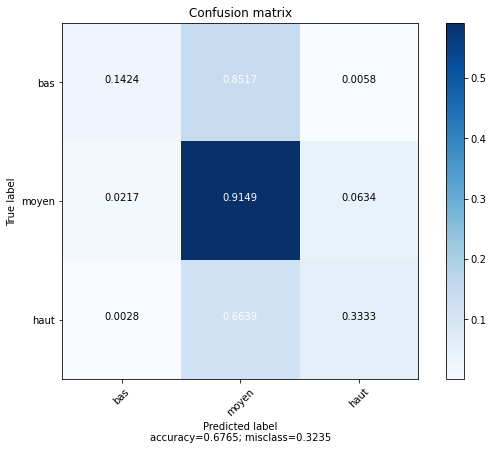

In [33]:
accuracy_random_sans_gdp, confusion_matrix = test_classifer(clf_multi_sans_gpd, test_data_sans_gdp)
plot_confusion_matrix(confusion_matrix, ['bas', 'moyen', 'haut'])
print("Accuracy: {0}".format(accuracy_random_sans_gdp))

## Compare les résultats avec et sans gdp
<br/>Avec GDP, le meilleur modèle trouvé est: max_depth=17, min_samples_split=10
<br/>Sans GDP, le meilleur modèle trouvé est: max_depth=18, min_samples_split=15
<br/>Nous obtenons une meilleure performance sans la colonne GDP

### 2.3.2 Comparaison avec les autres classeurs.
Conclusion: Les classeurs aléatoires sont les moins performants.
<br/>Les classeurs binaires sont plus performants, car il est plus simple de classer en 2 classes qu'en 3 classes.
<br/>Le splitter 'best' donne de meilleurs résultats que le splitter 'random'.
<br/>Nous notons que tous les classeurs arrivent à des valeurs de max_depth et min_samples_split semblables.

[]

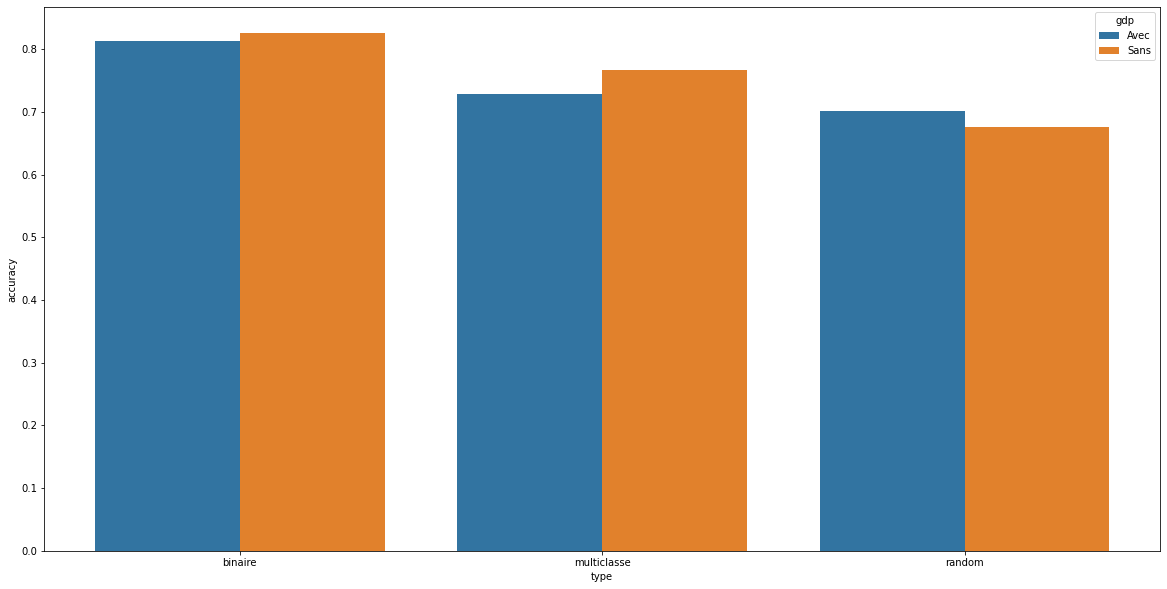

In [34]:
res_df = res_df.append(
    [
        {'type':'random', 'gdp':'Avec', 'accuracy':accuracy_random_avec_gdp},
        {'type':'random', 'gdp':'Sans', 'accuracy':accuracy_random_sans_gdp}
    ])
sns.barplot(data= res_df, x="type", y="accuracy", hue="gdp").plot()
plt.show()


### Fin du TP2